In [17]:
import pandas as pd
import numpy as np 
import ast
import pickle
from sklearn.preprocessing import MultiLabelBinarizer

In [18]:
df = pd.read_csv('movies_cleaned.csv')
df.head()

,title,budget,revenue,genres,top_cast,director,producers,composers,vote_average,release_month,runtime,vote_count
0,GoldenEye,58000000.0,352194034.0,"['Adventure', 'Action', 'Thriller']","['Pierce Brosnan', 'Sean Bean', 'Izabella Scor...",Martin Campbell,"['Barbara Broccoli', 'Michael G. Wilson', 'Ant...",['Eric Serra'],6.6,11,130.0,1194.0
1,Friday,3500000.0,28215918.0,['Comedy'],"['Ice Cube', 'Chris Tucker', 'Nia Long']",F. Gary Gray,[],[],7.0,4,91.0,513.0
2,From Dusk Till Dawn,19000000.0,25836616.0,"['Horror', 'Action', 'Thriller', 'Crime']","['George Clooney', 'Quentin Tarantino', 'Harve...",Robert Rodriguez,"['Gianni Nunnari', 'Meir Teper']",['Graeme Revell'],6.9,1,108.0,1644.0
3,Blue in the Face,2000000.0,1275000.0,['Comedy'],"['Harvey Keitel', 'Lou Reed', 'Michael J. Fox']",Wayne Wang,"['Peter Newman', 'Diana Phillips', 'Hisami Kur...",[],6.8,9,83.0,28.0
4,Mighty Morphin Power Rangers: The Movie,15000000.0,66000000.0,"['Action', 'Adventure', 'Science Fiction', 'Fa...","['Amy Jo Johnson', 'Jason David Frank', 'David...",Bryan Spicer,"['Suzanne Todd', 'Haim Saban']",['Graeme Revell'],5.2,6,92.0,153.0


When CSVs are loaded, lists become strings like "['Action']". 
We must turn them back into real lists.

In [19]:
list_cols = ['genres', 'top_cast', 'producers', 'composers']

for col in list_cols:
    if col in df.columns:

        df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else []))

In [20]:
mlb = MultiLabelBinarizer()
g_matrix = mlb.fit_transform(df['genres'])
g_matrix

array([[1, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]], shape=(539, 21))

In [21]:
genre_df = pd.DataFrame(g_matrix, columns=[f"Genre_{g}" for g in mlb.classes_])

In [22]:
genre_df.head()

,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_Foreign,...,Genre_History,Genre_Horror,Genre_Music,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Science Fiction,Genre_Thriller,Genre_War,Genre_Western
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [23]:
def create_power_dict(df, column_name):
    
    exploded = df.explode(column_name)
    stats = exploded.groupby(column_name).agg(
        mean_revenue=('revenue', 'mean'),
        count=('revenue', 'count')
    )
    
    return stats[stats['count'] >= 2]['mean_revenue'].to_dict()

def get_power_score(entity_list, known_values):
    
    if not isinstance(entity_list, list) or not entity_list:
        return 0
    revenues = [known_values.get(e, 0) for e in entity_list]
    return np.mean(revenues) if revenues else 0

In [24]:
known_actors = create_power_dict(df, 'top_cast')
df['star_power'] = df['top_cast'].apply(lambda x: get_power_score(x, known_actors))

In [25]:
known_composers = create_power_dict(df, 'composers')
df['composer_power'] = df['composers'].apply(lambda x: get_power_score(x, known_composers))

In [26]:
director_stats = df.groupby('director').agg(mean_revenue=('revenue', 'mean'), count=('revenue', 'count'))
known_directors = director_stats[director_stats['count'] >= 2]['mean_revenue'].to_dict()
df['director_power'] = df['director'].apply(lambda x: known_directors.get(x, 0))

In [27]:
numeric_cols = [
    'budget', 'runtime', 'vote_average', 'vote_count', 'release_month', 
    'star_power', 'director_power', 'composer_power', 
    'revenue'
]

In [28]:
final_data = pd.concat([df[numeric_cols], genre_df], axis=1)

In [29]:
final_data.dropna(inplace=True)
final_data.to_csv('movies_model_ready.csv', index=False)

In [30]:
final_data.shape

(539, 30)

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Actual Box Office Revenue')

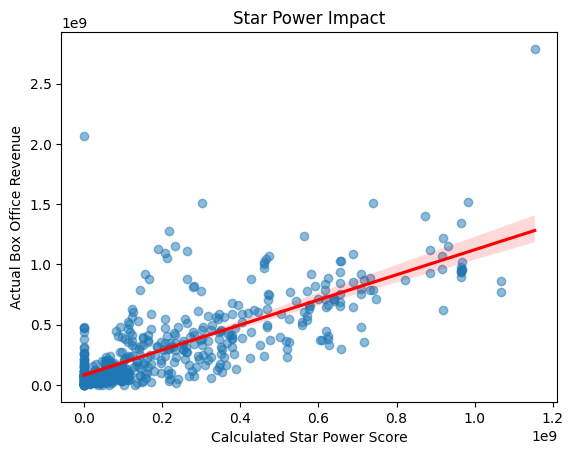

In [53]:
sns.regplot(data=final_data, x='star_power', y='revenue', line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
plt.title('Star Power Impact')
plt.xlabel('Calculated Star Power Score')
plt.ylabel('Actual Box Office Revenue')

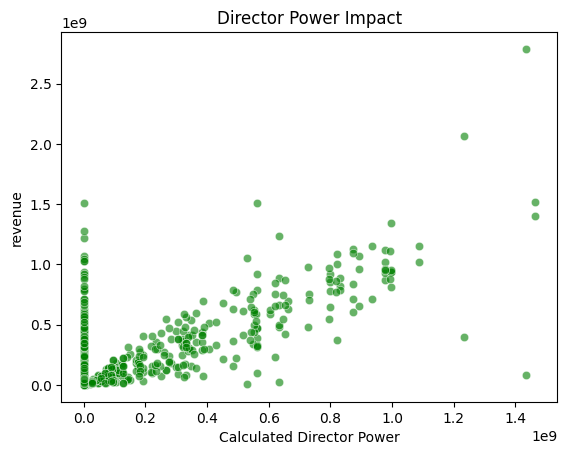

In [48]:
sns.scatterplot(data=final_data, x='director_power', y='revenue', alpha=0.6, color='green')
plt.title('Director Power Impact', fontsize=12)
plt.xlabel('Calculated Director Power')
plt.show()

In [31]:
artifacts = {
    'actor_power': known_actors,
    'director_power': known_directors,
    'composer_power': known_composers,
    'mlb': mlb
}

In [32]:
with open('model_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)